In [309]:
import pandas as pd
import os 
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np 
from sklearn.cluster import KMeans
from scipy import stats

import pickle

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import sklearn

from utils.network_analysis import *
from utils.neural_embedding import *

In [310]:
# Read in congressmember to party mapping table
filepath = 'data/raw/congressmembers_characteristics.csv'
all_congress_members = pd.read_csv(filepath).drop_duplicates('twitter_name')

democrats = all_congress_members[all_congress_members['party'] == 'D']
republicans = all_congress_members[all_congress_members['party'] == 'R']

democrats_congress_members = list(democrats['congressperson'])
republicans_congress_members = list(republicans['congressperson'])

house_list = list(all_congress_members[all_congress_members['chamber'] == 'House']['congressperson'])
senate_list = list(all_congress_members[all_congress_members['chamber'] == 'Senate']['congressperson'])

In [311]:
congressmembers = pd.read_csv('data/raw/congressmembers_characteristics.csv')[['party', 'congressperson']]

**COMBINED EMBEDDING**

In [326]:
embedding_dimension = 30

G_house_dict = {}
G_senate_dict = {}
for i in [1,2,3,5,10]:
    embeddings_path = f'data/processed/embeddings/embedding_combined_kout1_kin{i}_{embedding_dimension}.pkl'
    with open(embeddings_path, "rb") as input_file:
        embeddings_dct = pickle.load(input_file)

    house = {key:value for key,value in embeddings_dct.items() if key in house_list}
    senate = {key:value for key,value in embeddings_dct.items() if key in senate_list}

    G_house_dict[i] = house
    G_senate_dict[i] = senate

**SEPARATE EMBEDDING**

In [313]:
embedding_dimension_house = 30
embedding_dimension_senate = 10

G_h_house_dict = {}
G_s_senate_dict = {}
for i in [1,2,3,5,10]:
    embeddings_path_house = f'data/processed/embeddings/embedding_house_kout1_kin{i}_{embedding_dimension_house}.pkl'
    embeddings_path_senate = f'data/processed/embeddings/embedding_senate_kout1_kin{i}_{embedding_dimension_senate}.pkl'

    with open(embeddings_path_house, "rb") as input_file_house:
        embeddings_dct_house = pickle.load(input_file_house)
    G_h_house_dict[i] = embeddings_dct_house

    with open(embeddings_path_senate, "rb") as input_file_senate:
        embeddings_dct_senate = pickle.load(input_file_senate)
    G_s_senate_dict[i] = embeddings_dct_senate

## **1. Read embeddings vectors**

The output of the neural embedding process will be a dictionary object of structure {'username' : np.array} where np.array is an $n$-dimensional vector representing the embedding (in $n$-dimensional embedding space)

## **2. Run K-Means on embeddings**


In [314]:
def computeKMeans(data_dict, k=2):
    # Convert the dictionary values to a NumPy array
    features = np.array(list(data_dict.values()))

    # Initialize and fit the KMeans algorithm
    kmeans = KMeans(n_clusters=k, init='random')
    kmeans.fit(features)

    # Get the cluster labels
    labels = kmeans.labels_

    # If you want to associate labels with the original names:
    labeled_data = dict(zip(data_dict.keys(), labels))

    return labeled_data

In [420]:
def computeHomogeneityCompleteness(embeddings_dct, congressmembers, kin):
    """Input a dictionary of embeddings, return a list of 100 homogeneity and completeness scores as a result of K-means K=2"""
    
    embeddings_dct = embeddings_dct[kin]
    h_list = []
    c_list = []
    for i in range(100):
        embeddings_clustered = computeKMeans(embeddings_dct, 2)
        embeddings_clustered = pd.DataFrame.from_dict(embeddings_clustered, orient='index').reset_index().rename(columns={0: 'cluster_id', 'index' : 'congressperson'})
        table = embeddings_clustered.merge(congressmembers, on='congressperson', how='left')

        h_score = sklearn.metrics.homogeneity_score(table['party'], table['cluster_id'])
        c_score = sklearn.metrics.completeness_score(table['party'], table['cluster_id'])
        h_list.append(h_score)
        c_list.append(c_score)

    return h_list, c_list, kin

h_list, c_list, kin = computeHomogeneityCompleteness(G_house_dict, all_congress_members, kin=10)

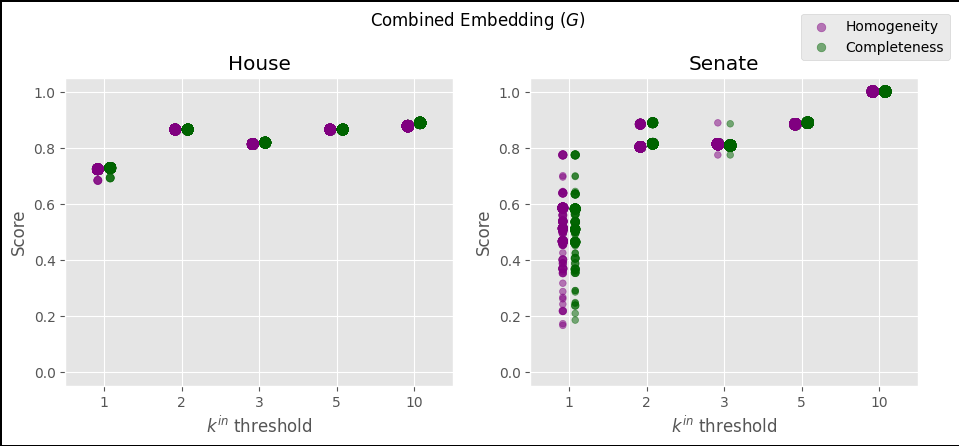

In [464]:
house = G_house_dict
senate = G_senate_dict
scale_factor=10
save=True
network_approach = 'combined'
with plt.style.context("ggplot"):
    
    fig, axs = plt.subplots(1, 2, figsize=(11, 4))
    for i,j in enumerate([1,2,3,5,10]):
        h_list_senate, c_list_senate, kin_senate = computeHomogeneityCompleteness(senate, all_congress_members, kin=j)
        h_list_house, c_list_house, kin_house = computeHomogeneityCompleteness(house, all_congress_members, kin=j)


        h_count_senate = [np.log(h_list_senate.count(i)*scale_factor)*scale_factor for i in h_list_senate]
        c_count_senate = [np.log(c_list_senate.count(i)*scale_factor)*scale_factor for i in c_list_senate]


        h_count_house = [np.log(h_list_house.count(i)*scale_factor)*scale_factor for i in h_list_house]
        c_count_house = [np.log(c_list_house.count(i)*scale_factor)*scale_factor for i in c_list_house]


        

        axs[0].scatter([i-0.08]*len(h_list_house), h_list_house, sizes=h_count_house, color='purple', alpha=0.5, label='Homogeneity')
        axs[0].scatter([i+0.08]*len(c_list_house), c_list_house, sizes=c_count_house, color='darkgreen', alpha=0.5, label='Completeness')

        axs[1].scatter([i-0.08]*len(h_list_senate), h_list_senate, sizes=h_count_senate, color='purple', alpha=0.5, label='Homogeneity')
        axs[1].scatter([i+0.08]*len(c_list_senate), c_list_senate, sizes=c_count_senate,color='darkgreen', alpha=0.5, label='Completeness')

    axs[0].set_title('House')
    axs[1].set_title('Senate')
    axs[1].legend(['Homogeneity', 'Completeness'],bbox_to_anchor=(1.1,1.23))

    for ax in axs:
        ax.set_xlabel(r'$k^{in}$ threshold')
        ax.set_ylabel('Score')
        ax.set_ylim([-0.05,1.05])
        ax.set_xlim([-0.5,4.5])
        ax.set_xticks([0,1,2,3,4])
        ax.set_xticklabels([1,2,3,5,10])

    fig.patch.set_edgecolor('black')  # Set border color
    fig.patch.set_linewidth(1) 

    plt.suptitle('Combined Embedding ($G$)', y=1.05)

    if save:
        current_ts = datetime.datetime.now().strftime("%Y_%m_%d__%H_%M_%S")
        plt.savefig('results/figures/ideology_grouping_thresholds_{}_{}'.format(network_approach,current_ts), bbox_inches='tight', dpi=400, format='pdf')

    plt.show()


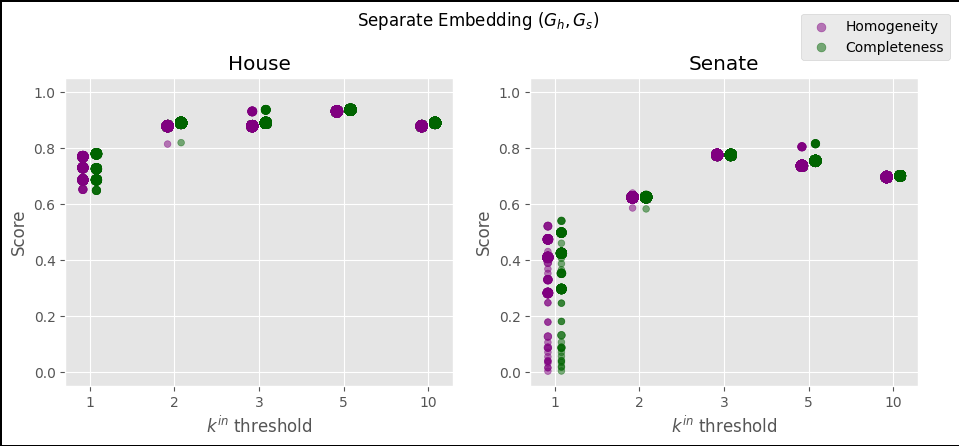

In [467]:
house = G_h_house_dict
senate = G_s_senate_dict
scale_factor=10
save=True
network_approach = 'separate'

with plt.style.context("ggplot"):
    
    fig, axs = plt.subplots(1, 2, figsize=(11, 4))
    for i,j in enumerate([1,2,3,5,10]):
        h_list_senate, c_list_senate, kin_senate = computeHomogeneityCompleteness(senate, all_congress_members, kin=j)
        h_list_house, c_list_house, kin_house = computeHomogeneityCompleteness(house, all_congress_members, kin=j)

        h_count_senate = [np.log(h_list_senate.count(i)*scale_factor)*scale_factor for i in h_list_senate]
        c_count_senate = [np.log(c_list_senate.count(i)*scale_factor)*scale_factor for i in c_list_senate]

        h_count_house = [np.log(h_list_house.count(i)*scale_factor)*scale_factor for i in h_list_house]
        c_count_house = [np.log(c_list_house.count(i)*scale_factor)*scale_factor for i in c_list_house]

        axs[0].scatter([i-0.08]*len(h_list_house), h_list_house, sizes=h_count_house, color='purple', alpha=0.5, label='Homogeneity')
        axs[0].scatter([i+0.08]*len(c_list_house), c_list_house, sizes=c_count_house, color='darkgreen', alpha=0.5, label='Completeness')

        axs[1].scatter([i-0.08]*len(h_list_senate), h_list_senate, sizes=h_count_senate, color='purple', alpha=0.5, label='Homogeneity')
        axs[1].scatter([i+0.08]*len(c_list_senate), c_list_senate, sizes=c_count_senate,color='darkgreen', alpha=0.5, label='Completeness')

    axs[0].set_title('House')
    axs[1].set_title('Senate')
    axs[1].legend(['Homogeneity', 'Completeness'],bbox_to_anchor=(1.1,1.23))

    for ax in axs:
        ax.set_xlabel(r'$k^{in}$ threshold')
        ax.set_ylabel('Score')
        ax.set_ylim([-0.05,1.05])
        ax.set_xticks([0,1,2,3,4])
        ax.set_xticklabels([1,2,3,5,10])

    fig.patch.set_edgecolor('black')  # Set border color
    fig.patch.set_linewidth(1) 

    plt.suptitle('Separate Embedding ($G_h, G_s$)', y=1.05)

    if save:
        current_ts = datetime.datetime.now().strftime("%Y_%m_%d__%H_%M_%S")
        plt.savefig('results/figures/ideology_grouping_thresholds_{}_{}'.format(network_approach,current_ts), bbox_inches='tight', dpi=400, format='pdf')

    plt.show()

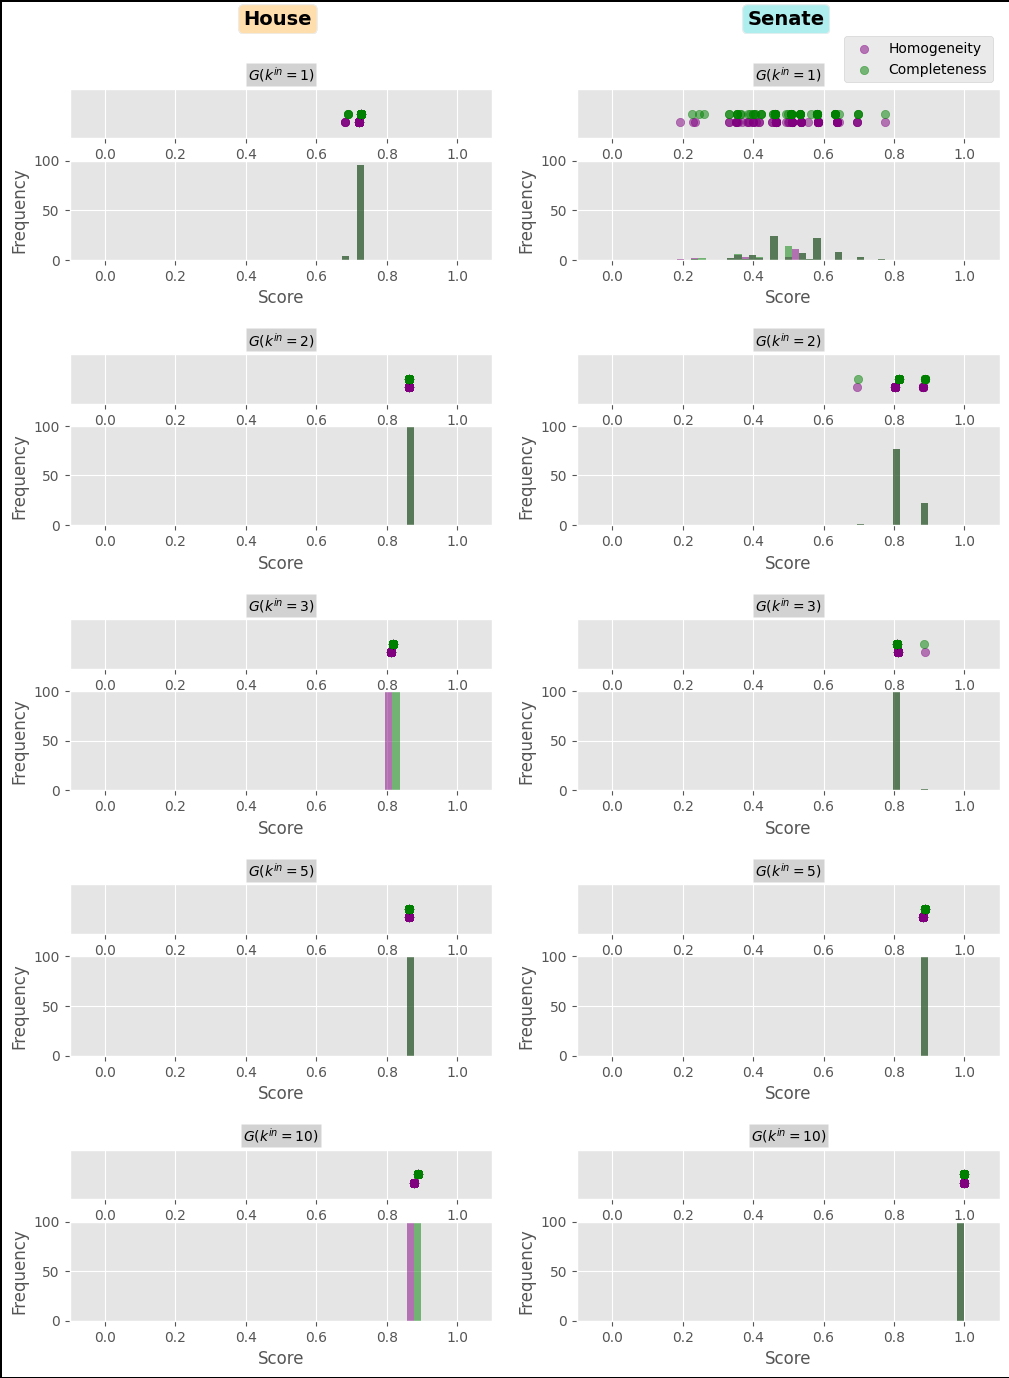

In [327]:
house = G_house_dict
senate = G_senate_dict
network_type = 'combined'
save=False


import matplotlib.gridspec as gridspec

with plt.style.context("ggplot"):
    fig = plt.figure(figsize=(12, 16))
    outer = gridspec.GridSpec(5, 2, wspace=0.2, hspace=0.55)

    for i,j in enumerate([1,1,2,2,3,3,5,5,10,10]):
        inner = gridspec.GridSpecFromSubplotSpec(2, 1,
                        subplot_spec=outer[i], wspace=0.05, hspace=0.3, height_ratios = [1,2])
        
        if i % 2 == 0:
            h_list,c_list,kin = computeHomogeneityCompleteness(house, all_congress_members, kin=j)
        else:
            h_list,c_list,kin = computeHomogeneityCompleteness(senate, all_congress_members, kin=j)

        
        ax1 = plt.Subplot(fig, inner[0])
        ax1.scatter(h_list, [0]*len(h_list), alpha=0.5, label='Homogeneity', color='purple')
        ax1.scatter(c_list, [0.05]*len(c_list), alpha=0.5, label='Completeness', color='green')
        ax1.set_yticks([])
        ax1.tick_params(labelbottom=True) 
        ax1.set_ylim([-0.1,0.2])
        ax1.set_xlim([-0.1,1.1])
        if network_type == 'combined':
            ax1.set_title(r'$G(k^{{in}}={})$'.format(kin),fontsize=10, bbox={'facecolor': 'grey', 'alpha': 0.35, 'pad': 1.5})
        else:
            if i % 2 == 0:
                ax1.set_title(r'$G_h(k^{{in}}={})$'.format(kin),fontsize=10,bbox={'facecolor': 'grey', 'alpha': 0.35, 'pad': 1.5})
            else:
                ax1.set_title(r'$G_s(k^{{in}}={})$'.format(kin),fontsize=10,bbox={'facecolor': 'grey', 'alpha': 0.35, 'pad': 1.5})


        #ax1.set_xlabel('Score', fontsize=12)
        

        if i ==1:
            ax1.legend(loc='upper right', bbox_to_anchor=(1,2.2))
        fig.add_subplot(ax1)
        bins = np.linspace(0,1,num=50)

        ax2 = plt.Subplot(fig, inner[1])
        ax2.hist(h_list,bins=bins,color='purple', alpha=0.5)
        ax2.hist(c_list,bins=bins, color='green', alpha=0.5)
        ax2.set_xlabel('Score', fontsize=12)
        ax2.set_ylabel('Frequency')
        ax2.set_xlim([-0.1,1.1])
        ax2.set_ylim([0,100])

        fig.add_subplot(ax2, sharex=ax1)

        fig.patch.set_edgecolor('black')  # Set border color
        fig.patch.set_linewidth(1) 

        plt.figtext(s = 'House', x=0.27, y=0.92, fontsize=14, fontweight='bold', bbox={'facecolor': 'navajowhite', 'alpha': 1, 'pad': 0.25, 'boxstyle' : 'round'})
        plt.figtext(s = 'Senate', x=0.69, y=0.92, fontsize=14, fontweight='bold', bbox={'facecolor': 'paleturquoise', 'alpha': 1, 'pad': 0.25, 'boxstyle' : 'round'})

    if save:
        current_ts = datetime.datetime.now().strftime("%Y_%m_%d__%H_%M_%S")
        plt.savefig('results/figures/ideological_grouping_{}_{}'.format(network_type,current_ts), bbox_inches='tight', dpi=400, format='pdf')


    plt.show()